# Phishing Site Predictor

### Import Libraries

In [2]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix
import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # provide object-oriented API for embedding plots into applications
%matplotlib inline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from PIL import Image
from bs4 import BeautifulSoup

### Loading Dataset

In [3]:
phish_data = pd.read_csv('phishing_site_urls.csv')

In [4]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [6]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [7]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

About the dataset: 
- dataset contains 549346 unique entries
- there are two columns:
    - URL column containing the website urls
    - Label column containing website url categorisation; good (not a phishing site) or bad (is a phishing site)
- there is no missing value in the dataset

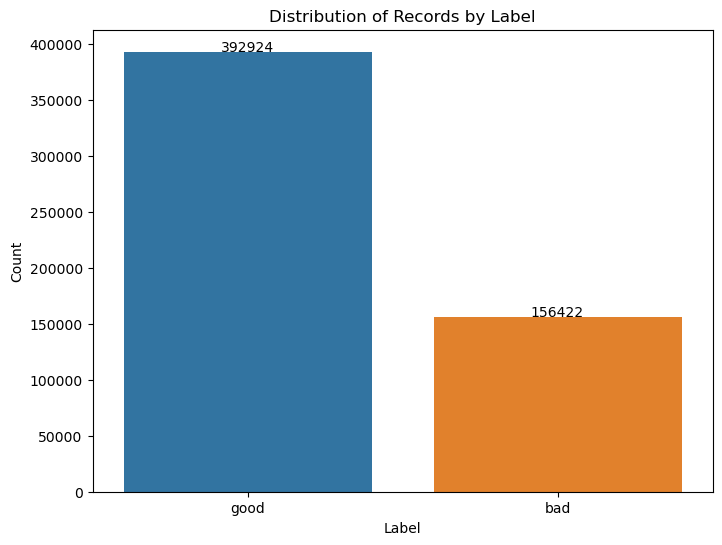

In [8]:
# Count occurence of records for each category in Label column
label_counts = phish_data['Label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values)

# Add count values on top of each bar
for i in range(len(label_counts)):
    barplot.text(x=i, y=label_counts.values[i] + 0.1, s=label_counts.values[i], ha='center')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Records by Label')

# Show the plot
plt.show()

### Data Preprocessing

RegexpTokenizer
- to extract the alphabet characters, disregarding the non-alphabetic characters from a link in the records in the dataset
- purpose is to extract more features from the data, to classify the web urls as good or bad sites

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [10]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [11]:
# tokenize first URL
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [12]:
# Create a new column named 'text_tokenized' in the phish_data DataFrame
# This column will store the tokens of alphabets extracted from the URLs
phish_data['text_tokenized'] = (
    # Apply a function to each URL in the 'URL' column
    # The function tokenizes each URL using the declared tokenizer object
    phish_data['URL'].map(lambda t: tokenizer.tokenize(t))
)

In [13]:
phish_data.sample(10)

,URL,Label,text_tokenized
183311,encyclopedia2.thefreedictionary.com/xylograph,good,"[encyclopedia, thefreedictionary, com, xylograph]"
415492,politiquebec.com/forum/topic28911.html,good,"[politiquebec, com, forum, topic, html]"
146598,au.linkedin.com/pub/john-agar-cfa-frm/11/39a/928,good,"[au, linkedin, com, pub, john, agar, cfa, frm, a]"
51849,www.hexintoys.com/index.html,good,"[www, hexintoys, com, index, html]"
7759,theprivynews.net/angeln/paypal/,bad,"[theprivynews, net, angeln, paypal]"
206164,lakers.topbuzz.com/PNphpBB2-viewtopic-t-42788....,good,"[lakers, topbuzz, com, PNphpBB, viewtopic, t, ..."
507014,pwleoujlrrvpwehe.pl/message.php,bad,"[pwleoujlrrvpwehe, pl, message, php]"
289696,bdsmqueens.com/models/M/missy_monroe.html,good,"[bdsmqueens, com, models, M, missy, monroe, html]"
198590,howmanyofme.com/people/John_Hurt/,good,"[howmanyofme, com, people, John, Hurt]"
274115,amazon.com/Besnard-Lakes-Are-Roaring-Night/dp/...,good,"[amazon, com, Besnard, Lakes, Are, Roaring, Ni..."


SnowballStemmer
- is a stemming algorithm used for reducing words to their root or base form 
- it is applied after tokenization to further preprocess the text data, normalizing it so that we can better process the text


In [14]:
stemmer = SnowballStemmer("english")

In [15]:
# Create a new column named 'text_stemmed' in the phish_data DataFrame
# Applying stemming to the tokenized words in the 'text_tokenized' column
phish_data['text_stemmed'] = (
    phish_data['text_tokenized'].map(lambda s: 
        # Iterate over each word in the tokenized list
        # and apply stemming using the SnowballStemmer object that we declared earlier
        [stemmer.stem(word) for word in s]
    )
)

In [16]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed
432861,snucampforchamps.com/,good,"[snucampforchamps, com]","[snucampforchamp, com]"
298285,canada411.ca/Quebec/Brossard/Abbott-to-Chung/C...,good,"[canada, ca, Quebec, Brossard, Abbott, to, Chu...","[canada, ca, quebec, brossard, abbott, to, chu..."
446670,theundergrowth.com/news.html,good,"[theundergrowth, com, news, html]","[theundergrowth, com, news, html]"
324193,evri.com/person/adrion-smith-0xa5c78,good,"[evri, com, person, adrion, smith, xa, c]","[evri, com, person, adrion, smith, xa, c]"
434867,speroforum.com/a/17483/Universal-Pictures-surp...,good,"[speroforum, com, a, Universal, Pictures, surp...","[speroforum, com, a, univers, pictur, surpass,..."
289872,bedfordshirefa.com/FixturesAndResults/CountyCu...,good,"[bedfordshirefa, com, FixturesAndResults, Coun...","[bedfordshirefa, com, fixturesandresult, count..."
91700,www.panix.com/~sos/bc/mysticwar.html,good,"[www, panix, com, sos, bc, mysticwar, html]","[www, panix, com, sos, bc, mysticwar, html]"
503589,aycilinsaat.com/vdG76VUY76rjnu/,bad,"[aycilinsaat, com, vdG, VUY, rjnu]","[aycilinsaat, com, vdg, vuy, rjnu]"
192986,genforum.genealogy.com/maddox/messages/2495.html,good,"[genforum, genealogy, com, maddox, messages, h...","[genforum, genealog, com, maddox, messag, html]"
189575,forums.canadian-tv.com/showthread.php?4006-Vid...,good,"[forums, canadian, tv, com, showthread, php, V...","[forum, canadian, tv, com, showthread, php, vi..."


We will combine the stemmed words into single strings by joining them together with spaces. It helps to simplify the representation of text data, and making it more suitable for analysis, visualisation, and modeling purposes.

In [17]:
# Create a new column named 'text_sent' in the DataFrame 'phish_data'
phish_data['text_sent'] = (
    phish_data['text_stemmed'].map(lambda j: 
        # Join the stemmed words in each list into a single string separated by spaces
        ' '.join(j)
    )
)

In [18]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
144917,articles.businessinsider.com/2011-06-27/wall_s...,good,"[articles, businessinsider, com, wall, street,...","[articl, businessinsid, com, wall, street, gol...",articl businessinsid com wall street goldman s...
451878,trueknowledge.com/q/facts_about__connecticut_c...,good,"[trueknowledge, com, q, facts, about, connecti...","[trueknowledg, com, q, fact, about, connecticu...",trueknowledg com q fact about connecticut coloni
387228,menuism.com/restaurants/charlie-orourkes-houst...,good,"[menuism, com, restaurants, charlie, orourkes,...","[menuism, com, restaur, charli, orourk, houston]",menuism com restaur charli orourk houston
197135,historywarsweapons.com/history-of-england-jame...,good,"[historywarsweapons, com, history, of, england...","[historywarsweapon, com, histori, of, england,...",historywarsweapon com histori of england jame ...
389576,minnesotafishingonline.com/lake_vermilion.html,good,"[minnesotafishingonline, com, lake, vermilion,...","[minnesotafishingonlin, com, lake, vermilion, ...",minnesotafishingonlin com lake vermilion html
516500,bg1337.zapto.org:1155,bad,"[bg, zapto, org]","[bg, zapto, org]",bg zapto org
198304,hotel-rhine-lorelei.com/,good,"[hotel, rhine, lorelei, com]","[hotel, rhine, lorelei, com]",hotel rhine lorelei com
139353,61yardsale.com/,good,"[yardsale, com]","[yardsal, com]",yardsal com
538390,dedivan.ru/index.php?categoryID=59,bad,"[dedivan, ru, index, php, categoryID]","[dedivan, ru, index, php, categoryid]",dedivan ru index php categoryid
93149,www.angelfire.com/trek/georgewbush/,good,"[www, angelfire, com, trek, georgewbush]","[www, angelfir, com, trek, georgewbush]",www angelfir com trek georgewbush


### Visualisation